<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-deepar"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [1]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Install pip packages

In [2]:
!pip install mxnet
!pip install gluonts

In [3]:
import pandas as pd

task = 2
# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task}/train{task}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task-1}/benchmark{'0' + str(task-1) if task-1 < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

In [4]:
solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)
train_data

,ZONEID 1,ZONEID 2,ZONEID 3
TIMESTAMP,,,
2012-04-01 01:00:00,0.754103,0.647328,0.799000
2012-04-01 02:00:00,0.555000,0.621822,0.817500
2012-04-01 03:00:00,0.438397,0.472692,0.571500
2012-04-01 04:00:00,0.145449,0.098866,0.063775
2012-04-01 05:00:00,0.111987,0.104393,0.103700
...,...,...,...
2013-04-30 20:00:00,0.000000,0.000000,0.000000
2013-04-30 21:00:00,0.002308,0.001680,0.004350
2013-04-30 22:00:00,0.063077,0.057530,0.130300


In [5]:
predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)[:'2013-05-01 00:00']
# April is prediction month

,SURFACE SOLAR RADIATION 1,SURFACE THERMAL RADIATION 1,TOP NET SOLAR RADIATION 1,SURFACE SOLAR RADIATION 2,SURFACE THERMAL RADIATION 2,TOP NET SOLAR RADIATION 2,SURFACE SOLAR RADIATION 3,SURFACE THERMAL RADIATION 3,TOP NET SOLAR RADIATION 3
TIMESTAMP,,,,,,,,,
2012-04-01 01:00:00,2577830.0,1202532.0,2861797.0,2595302.0,1192092.0,2884677.0,2606438.0,1158284.0,2901861.0
2012-04-01 02:00:00,5356093.0,2446757.0,5949378.0,5374973.0,2420485.0,5984578.0,5352637.0,2341093.0,5980930.0
2012-04-01 03:00:00,7921788.0,3681336.0,8939176.0,7858492.0,3643656.0,8929064.0,7714300.0,3531304.0,8822632.0
2012-04-01 04:00:00,9860520.0,4921504.0,11331679.0,9719720.0,4885120.0,11258463.0,9619368.0,4740096.0,11178847.0
2012-04-01 05:00:00,11143097.0,6254380.0,13105558.0,11054009.0,6211372.0,13079318.0,11054009.0,6014412.0,13079958.0
...,...,...,...,...,...,...,...,...,...
2013-04-30 20:00:00,7660269.0,23632608.0,10092771.0,6776557.0,23596000.0,9423971.0,6009325.0,23165536.0,8828003.0
2013-04-30 21:00:00,7666523.0,24855424.0,10108621.0,6783323.0,24789632.0,9439821.0,6016603.0,24302592.0,8843853.0
2013-04-30 22:00:00,7884472.0,26125232.0,10490204.0,7041208.0,26000688.0,9850588.0,6336696.0,25420208.0,9301340.0


In [6]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()
predictor_data

,SURFACE SOLAR RADIATION 1,SURFACE THERMAL RADIATION 1,TOP NET SOLAR RADIATION 1,SURFACE SOLAR RADIATION 2,SURFACE THERMAL RADIATION 2,TOP NET SOLAR RADIATION 2,SURFACE SOLAR RADIATION 3,SURFACE THERMAL RADIATION 3,TOP NET SOLAR RADIATION 3
TIMESTAMP,,,,,,,,,
2012-04-01 01:00:00,0.075576,0.035187,0.076927,0.075777,0.035046,0.077176,0.075711,0.034431,0.077220
2012-04-01 02:00:00,0.157027,0.071594,0.159924,0.156937,0.071159,0.160110,0.155482,0.069591,0.159157
2012-04-01 03:00:00,0.232247,0.107719,0.240292,0.229450,0.107119,0.238886,0.224083,0.104972,0.234776
2012-04-01 04:00:00,0.289086,0.144007,0.304604,0.283794,0.143616,0.301206,0.279421,0.140904,0.297477
2012-04-01 05:00:00,0.326688,0.183008,0.352287,0.322752,0.182606,0.349920,0.321094,0.178785,0.348067
...,...,...,...,...,...,...,...,...,...
2013-04-30 20:00:00,0.224580,0.691510,0.271301,0.197860,0.693692,0.252126,0.174557,0.688620,0.234919
2013-04-30 21:00:00,0.224763,0.727290,0.271727,0.198058,0.728783,0.252550,0.174769,0.722420,0.235341
2013-04-30 22:00:00,0.231153,0.764446,0.281984,0.205587,0.764386,0.263540,0.184067,0.755642,0.247515


In [7]:
# define the parameters of the dataset
gefcom14_metadata = {'num_series': 3,
                     'num_steps': 24 * (365 + 30),
                     'prediction_length': 24 * 30, # 1 month (April)
                     'freq': '1H',
                     'start': [pd.Timestamp("2012-04-01 01:00", freq='1H') for _ in range(3)]
                     }

In [8]:
targets = [train_data[:-gefcom14_metadata['prediction_length']][f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[:-gefcom14_metadata['prediction_length']][[f'SURFACE SOLAR RADIATION {i}', f'SURFACE THERMAL RADIATION {i}', f'TOP NET SOLAR RADIATION {i}']].values.T for i in [1,2,3]]

In [9]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

In [10]:
targets = [train_data[f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[[f'SURFACE SOLAR RADIATION {i}', f'SURFACE THERMAL RADIATION {i}', f'TOP NET SOLAR RADIATION {i}']].values.T for i in [1,2,3]]

In [11]:
test_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

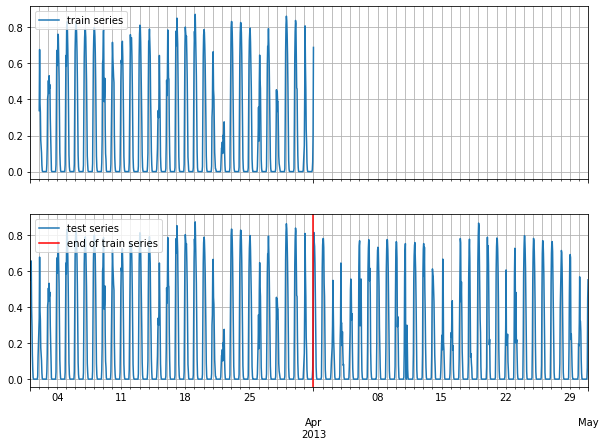

In [12]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series[-24*30:].plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series[-24*61:].plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [13]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import PiecewiseLinearOutput

estimator = DeepAREstimator(freq=gefcom14_metadata['freq'],
                            prediction_length=gefcom14_metadata['prediction_length'],
                            distr_output=PiecewiseLinearOutput(num_pieces=2), # SQF-RNN
                            use_feat_dynamic_real=True,
                            trainer=Trainer(epochs=10))

predictor = estimator.train(train_ds)

Multiprocessing is not supported on Windows, num_workers will be set to None.
  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [01:13<00:00,  1.47s/it, epoch=10/10, avg_epoch_loss=0.023] 


In [14]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1000,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

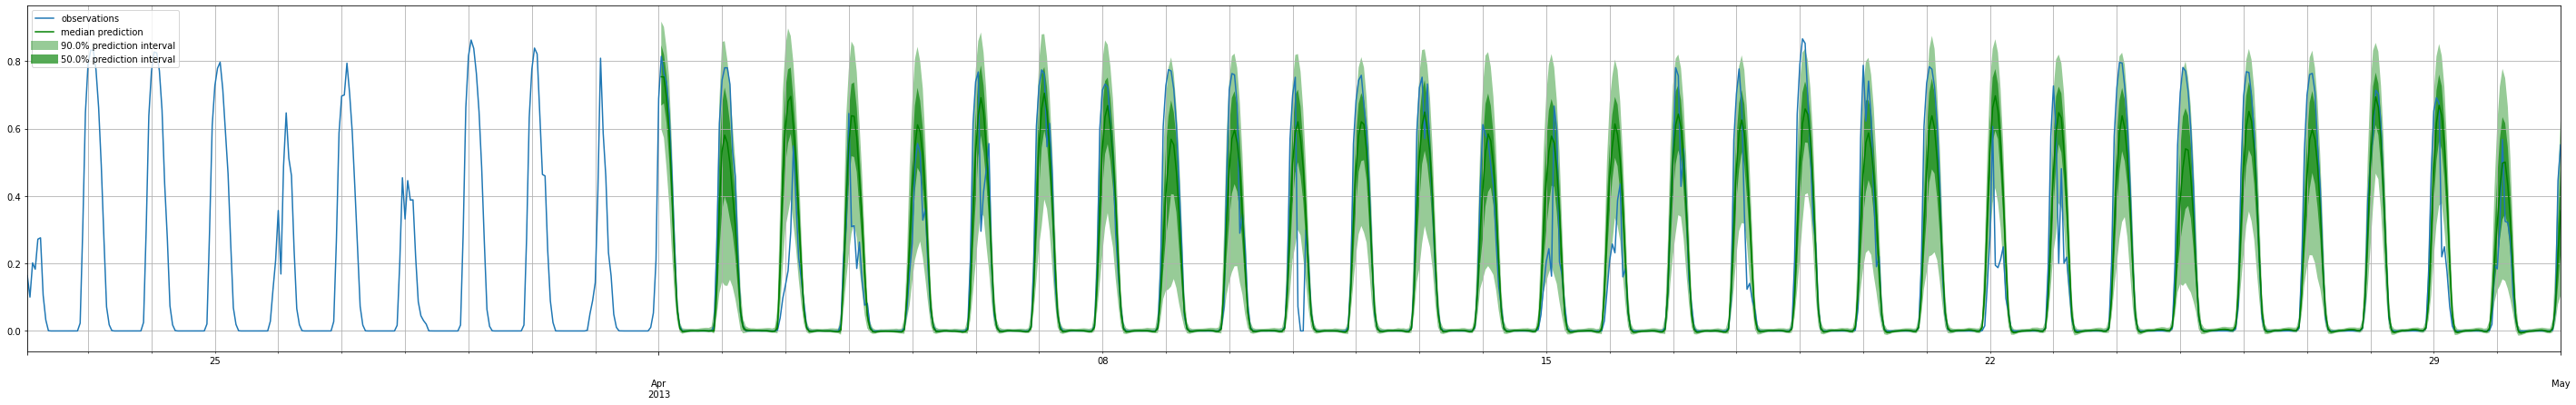

In [15]:
def plot_prob_forecasts(ts_entry, forecast_entry, output_file=None):
    plot_length = 24 * 40
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(50, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

plot_prob_forecasts(tss[0], forecasts[0])

In [16]:
import numpy as np

zone_predictions = []
for i, forecast in enumerate(forecasts):
    prediction = pd.concat([np.maximum(forecast.quantile_ts(p/100), 0)
                            for p in range(1, 100)], axis=1)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    prediction.insert(0, 'ZONEID', i+1)
    prediction.index.name = 'TIMESTAMP'
    zone_predictions.append(prediction)

predictions = pd.concat(zone_predictions)
predictions.to_csv('predictions.csv')
predictions

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-04-01 01:00:00,1,0.582328,0.587126,0.589865,0.593372,0.597788,0.599789,0.602884,0.604274,0.607806,...,0.899005,0.901667,0.906476,0.909247,0.913603,0.916829,0.919875,0.924270,0.926485,0.931114
2013-04-01 02:00:00,1,0.529011,0.539557,0.552660,0.562033,0.572405,0.578598,0.586972,0.596723,0.602985,...,0.874946,0.878480,0.884685,0.892027,0.894450,0.901030,0.909103,0.912658,0.918986,0.930314
2013-04-01 03:00:00,1,0.414894,0.440495,0.458702,0.473547,0.481782,0.494594,0.506143,0.519919,0.524747,...,0.808006,0.813198,0.819685,0.825349,0.833302,0.838096,0.845513,0.852292,0.863434,0.877447
2013-04-01 04:00:00,1,0.295834,0.319143,0.337844,0.360891,0.375221,0.392862,0.401187,0.408962,0.414632,...,0.716990,0.723498,0.729208,0.735876,0.742145,0.747923,0.753976,0.769088,0.780974,0.795980
2013-04-01 05:00:00,1,0.170319,0.194596,0.210163,0.223799,0.234718,0.249108,0.260303,0.268254,0.274750,...,0.528702,0.531209,0.537781,0.542363,0.549147,0.558935,0.565601,0.574492,0.584565,0.596518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-04-30 20:00:00,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009491,0.009961,0.010636,0.011361,0.012481,0.013060,0.013882,0.014873,0.015854,0.017513
2013-04-30 21:00:00,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000622,0.001208,0.001731,...,0.049227,0.050349,0.051124,0.053142,0.054888,0.057077,0.061542,0.064560,0.071868,0.077248
2013-04-30 22:00:00,3,0.040113,0.042990,0.046584,0.048579,0.050704,0.052817,0.055045,0.058099,0.061784,...,0.265369,0.268142,0.275142,0.279398,0.284909,0.294591,0.299977,0.306745,0.316982,0.337046


## Plotting the quantile prediction for the first entries

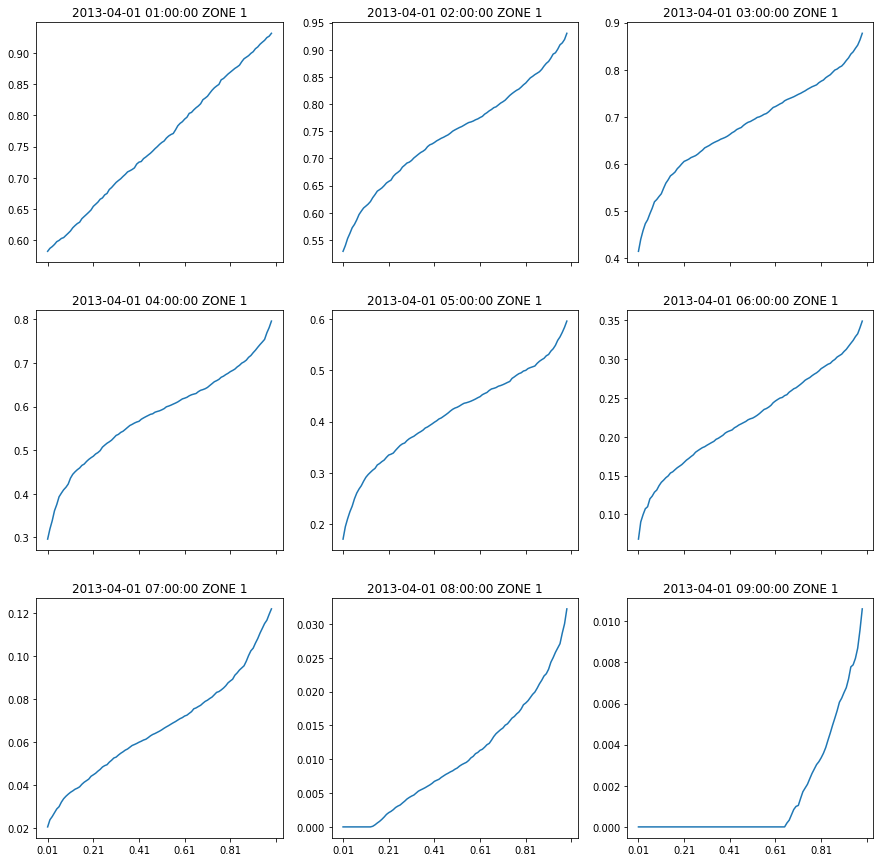

In [17]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    predictions.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3], 
                                      title=str(predictions.index[i]) + ' ZONE ' 
                                      + str(int(predictions.iloc[i]['ZONEID'])))

# Evaluate Loss

The loss function is the pinnball loss: 
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [18]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction, 
                    (1 - percentiles / 100) * (prediction - actual), 
                    percentiles / 100 * (actual - prediction))
    return loss

loss1 = np.mean(pinnball_loss(tss[0].values[-24*30:,0], predictions[predictions['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-24*30:,0], predictions[predictions['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-24*30:,0], predictions[predictions['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Loss of task 2: 0.01845


In [20]:
loss1 = np.mean(pinnball_loss(tss[0].values[-24*30:,0], benchmark[benchmark['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-24*30:,0], benchmark[benchmark['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-24*30:,0], benchmark[benchmark['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Benchmark loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Benchmark loss of task 2: 0.03493
